# Playing Valid Chess Moves

!!! note
    To download this example as a Jupyter notebook, click [here](https://github.com/guardrails-ai/guardrails/blob/main/docs/examples/valid_chess_moves.ipynb).

!!! warning
    This example is currently under development (it cannot be used to play a full chess game yet).

In this example, we will use Guardrails to play chess with an LLM and ensure that it makes valid moves.

## Objective

We want to generate a valid chess moves for a given board state.

In [2]:
import guardrails as gd
from rich import print

/Users/dtam/.pyenv/versions/3.12.3/envs/litellm/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
! pip install chess --quiet

## Step 1: Create the RAIL Spec

Ordinarily, we would create an RAIL spec in a separate file. For the purposes of this example, we will create the spec in this notebook as a string following the RAIL syntax. For more information on RAIL, see the [RAIL documentation](/docs/how_to_guides/rail).  We will also show the same RAIL spec in a code-first format using a Pydantic model.

First we define a custom Validator:

In [3]:
from guardrails.validators import Validator, register_validator, ValidationResult, PassResult, FailResult

from typing import Dict, Any

import chess

BOARD = chess.Board()

@register_validator(name="is-valid-chess-move", data_type="string")
class IsValidChessMove(Validator):

    board = BOARD

    def validate(self, value: Any, metadata: Dict) -> ValidationResult:
        global BOARD
        try:
            # Push the move onto the board.
            BOARD.push_san(value)
        except Exception as e:
            # If the move is invalid, raise an error.
            return FailResult(
                error_message=f"Value {value} is not a valid chess move. {e}"
            )        

        return PassResult()

Then we can define our RAIL spec either as XML:

In [4]:
rail_str = """
<rail version="0.1">

<output>
    <string description="A move in standard algebraic notation." name="move" required="true" format="is-valid-chess-move" on-fail-is-valid-chess-move="reask" />
</output>


<messages>
<message role="user">
Generate a move for the chess board. Do not repeat any moves in the following state. The board is currently in the following state:
${board_state}
${gr.complete_xml_suffix}
</message>
</messages>

</rail>
"""

Or as a Pydantic model:

In [5]:
from pydantic import BaseModel, Field

prompt = """
Generate a move for the chess board. Do not repeat any moves in the following state. The board is currently in the following state:
${board_state}
${gr.complete_xml_suffix}
"""

class ChessMove(BaseModel):
    move: str = Field(
        description="A move in standard algebraic notation.",
        validators=[IsValidChessMove(on_fail="reask")]
        )

## Step 2: Create a `Guard` object with the RAIL Spec

We create a `gd.Guard` object that will check, validate and correct the output of the LLM. This object:

1. Enforces the quality criteria specified in the RAIL spec.
2. Takes corrective action when the quality criteria are not met.
3. Compiles the schema and type info from the RAIL spec and adds it to the prompt.

From XML:

In [6]:
guard = gd.Guard.for_rail_string(rail_str)

From a Pydantic model:

In [7]:
guard = gd.Guard.for_pydantic(output_class=ChessMove)

Let's get the reference to the board.

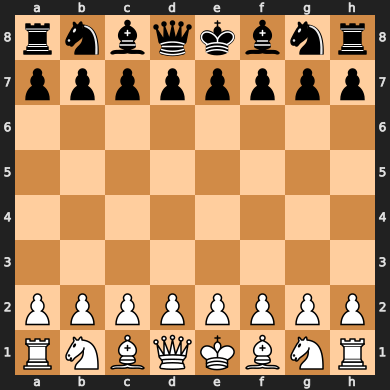

In [8]:
board = guard._validator_map.get("$.move")[0].board
board

## Step 3: Wrap the LLM API call with `Guard`

In [9]:
# Set your OPENAI_API_KEY as an environment variable
# import os
# os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

raw_llm_response, validated_response, *rest = guard(
    messages=[{"role":"user", "content": prompt}],
    prompt_params={
        "board_state": str(board.move_stack)
        if board.move_stack
        else "Starting position."
    },
    model="gpt-4o-mini",
    max_tokens=2048,
    temperature=0.3,
)

/Users/dtam/dev/guardrails/guardrails/validator_service/__init__.py:85: UserWarning: Could not obtain an event loop. Falling back to synchronous validation.
  warnings.warn(


We can see in the prompt that was sent to the LLM, the `{board_state}` parameter is substituted with the current state of the board.

In [10]:
print(guard.history.last.iterations.last.inputs.messages[0]["content"])

Generate a move for the chess board. Do not repeat any moves in the following state. The board is currently in the 
following state:
Starting position.

Given below is XML that describes the information to extract from this document and the tags to extract it into.

<output>
  <string description="A move in standard algebraic notation." format="is-valid-chess-move" name="move" 
required="true"></string>
</output>

ONLY return a valid JSON object (no other text is necessary), where the key of the field in JSON is the `name` 
attribute of the corresponding XML, and the value is of the type specified by the corresponding XML's tag. The JSON
MUST conform to the XML format, including any types and format requests e.g. requests for lists, objects and 
specific types. Be correct and concise. If you are unsure anywhere, enter `null`.

Here are examples of simple (XML, JSON) pairs that show the expected behavior:
- `<string name='foo' format='two-words lower-case' />` => `{'foo': 'example one'}`
- `<list name='bar'><string format='upper-case' /></list>` => `{"bar": ['STRING ONE', 'STRING TWO', etc.]}`
- `<object name='baz'><string name="foo" format="capitalize two-words" /><integer name="index" format="1-indexed" 
/></object>` => `{'baz': {'foo': 'Some String', 'index': 1}}`

The `guard` wrapper returns the raw_llm_respose (which is a simple string), and the validated and corrected output (which is a dictionary).

We can see that the output is a dictionary with the correct schema and types.

In [11]:
print(validated_response)

{'move': 'e4'}

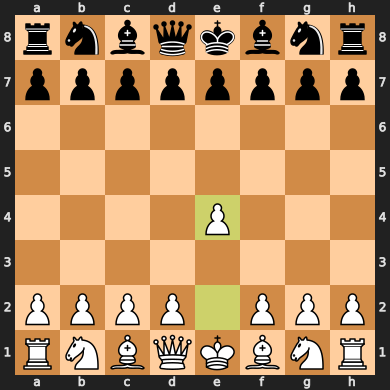

In [12]:
board

Let's make a move.

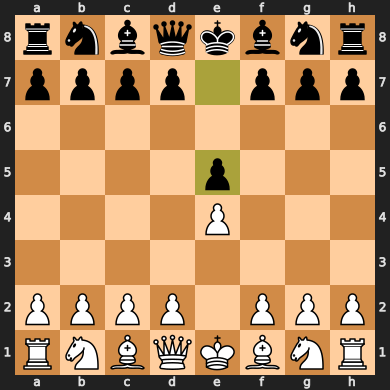

In [13]:
board.push_san("e5")
board

Ask for another move from the model.

In [14]:
raw_llm_response, validated_response, *rest = guard(
    messages=[{"role":"user", "content": prompt}],
    prompt_params={
        "board_state": str(board.move_stack)
    },
    model="gpt-4o-mini",
    max_tokens=2048,
    temperature=0.0,
)

/Users/dtam/dev/guardrails/guardrails/validator_service/__init__.py:85: UserWarning: Could not obtain an event loop. Falling back to synchronous validation.
  warnings.warn(


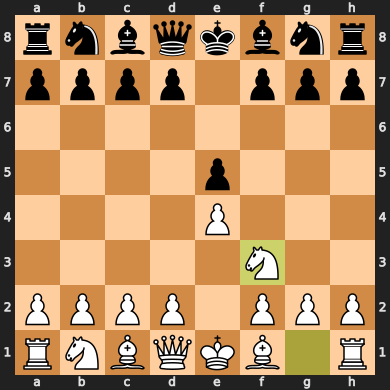

In [15]:
board

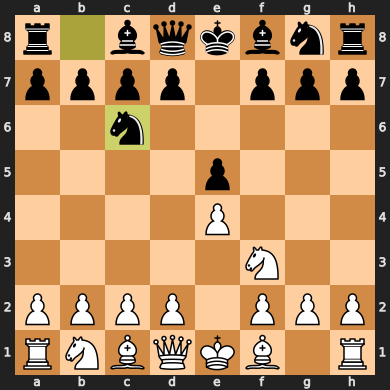

In [16]:
board.push_san("Nc6")
board